# Recurrent spiking neural networks

This notebook provides a computational pipeline to:
* Set up a recurrent-spiking neural network.
* Generate data to give to it as input.
* Train the network so that it matches the data.
* Provide some examples on what type of analysis can be done on the trained network.

This notebook has been built following:
* [The CURBD tool](https://github.com/rajanlab/CURBD)
* The notebooks provided by Rajan Lab at this [link](https://www.rajanlab.com/cosyne2021)

# Importing libraries

In [ ]:
import numpy as np #Vector and matrix operations
import matplotlib.pyplot as plt #Plotting
import numpy.random as npr #Random number generation
import math #Math operations
import scipy as sp #Scientific computing
from sklearn.decomposition import PCA #Principal component analysis methods

# Creating the network

## Neurons
Neurons are modeled by the time evolution of their membrane potential $V$:

$$\tau\frac{dV_{i}}{dt} = -V + g\sum\limits_{j}J_{ij}\phi(V_{j}) + I_{i}$$

This differential equation is solved using the Euler method, so the evolution of the voltage from one timestep to another is:

$$V_{i}(t + \Delta t) = V_{i}(t) + \frac{-V_{i}(t) + g\sum\limits_{j}J_{ij}\phi(V_{j}(t)) + I_{i}(t)}{\tau}\Delta t$$

Where:

* $\phi(V)$ is a non-linear activation function, representing the firing rate of the neuron.
* $J_{ij}$ is the strenght of the synapses going from neuron $j$ to neuron $i$.
* g is the conductance of input synapses. It is chosen to be large enough as to favour complex dynamics (usually $>1$).
* $\tau$ is the time constant of the neuron.

In [1]:
n_neurons = 300
g = 1.5 #Neuron's conductance
tau_neuron = 0.1 #Neuron's time constant

#The neurons in the network are represented by a vector containing the membrane
#potential value for each one of them.
def init_neurons(n_neurons):
    return npr.normal(
            -0.7, #Minimum value
            0.7, #Maximum value
            (n_neurons, 1) #(n_neurons, n_timesteps)
            )

init_neurons(n_neurons)

array([[-1.0877368 ],
       [-0.4776055 ],
       [ 0.36287468],
       [-0.30486468],
       [-1.07039686],
       [-0.52268979],
       [-0.51858265],
       [-0.74864996],
       [-1.33385593],
       [-1.18455314],
       [-0.16592712],
       [-1.70292337],
       [-0.72270695],
       [ 0.5131129 ],
       [-1.39892263],
       [-0.68323425],
       [-0.08647051],
       [-0.55260828],
       [ 0.32992672],
       [ 0.28488581],
       [-1.27823765],
       [ 0.13208397],
       [-0.42616703],
       [-0.48577981],
       [-0.47239049],
       [-0.34698495],
       [-1.62456706],
       [-0.8810494 ],
       [-1.6619195 ],
       [-0.74218405],
       [-0.48484855],
       [ 0.60134315],
       [ 0.4282243 ],
       [-0.74831198],
       [ 0.61548363],
       [ 0.44382978],
       [-0.67504202],
       [-1.64740033],
       [-0.11791356],
       [-0.89514478],
       [-0.97434152],
       [ 0.01034092],
       [-1.10109109],
       [-1.84364004],
       [-0.84136317],
       [-1

In [ ]:
#The activity, or firing rate is the output of the non-linear activation
#function applied to the membrane potential.
def get_activity(V, phi):
    return phi(V)

#The voltage is updated with Euler's method
def update_voltage(V, g, J, I, activity, tau, dt):
    return V + (-V + g * J.dot(activity) + I) * dt / tau

## Synapses
The synapses are represented as a matrix $J$ of size $n \times n$. where $n$ is the number of neurons.
The value of $J_{ij}$ represents the strength of the connection between neuron $i$ and neuron $j$, such that:
* $J_{ij} > 0$ means that neuron $i$ excites neuron $j$.
* $J_{ij} < 0$ means that neuron $i$ inhibits neuron $j$.
* $J_{ij} = 0$ means that there is no connection between neuron $i$ and neuron $j$.

The matrix is initialized with random values distributed as a normal distribution and then normalized according to the number of neurons $n$:

$$J_{ij} \sim \frac{N(0, 1)}{\sqrt{n}}$$

In [2]:
#The synapses in the network are initialized as a random square matrix,
#where rows represent the source neuron and the columns the target
def init_synapses(n_neurons):
    return npr.randn(n_neurons, n_neurons) / math.sqrt(n_neurons)
init_synapses(n_neurons)

array([[-0.02791304,  0.04034485, -0.00020465, ..., -0.02267418,
        -0.03028357,  0.00528288],
       [ 0.02485661, -0.02391059,  0.0374604 , ...,  0.0047987 ,
         0.06077433,  0.03430306],
       [ 0.05241727,  0.04052171,  0.00216969, ...,  0.03658625,
         0.02232249,  0.04050247],
       ...,
       [-0.05636779,  0.00857663,  0.01881343, ...,  0.0345722 ,
         0.11570139,  0.00619258],
       [-0.00732375,  0.03712757,  0.13550623, ...,  0.0211886 ,
        -0.03126354, -0.0040725 ],
       [-0.03155509,  0.03761611, -0.10094834, ..., -0.03563188,
         0.06991641, -0.11340347]])

Installed qt5 event loop hook.


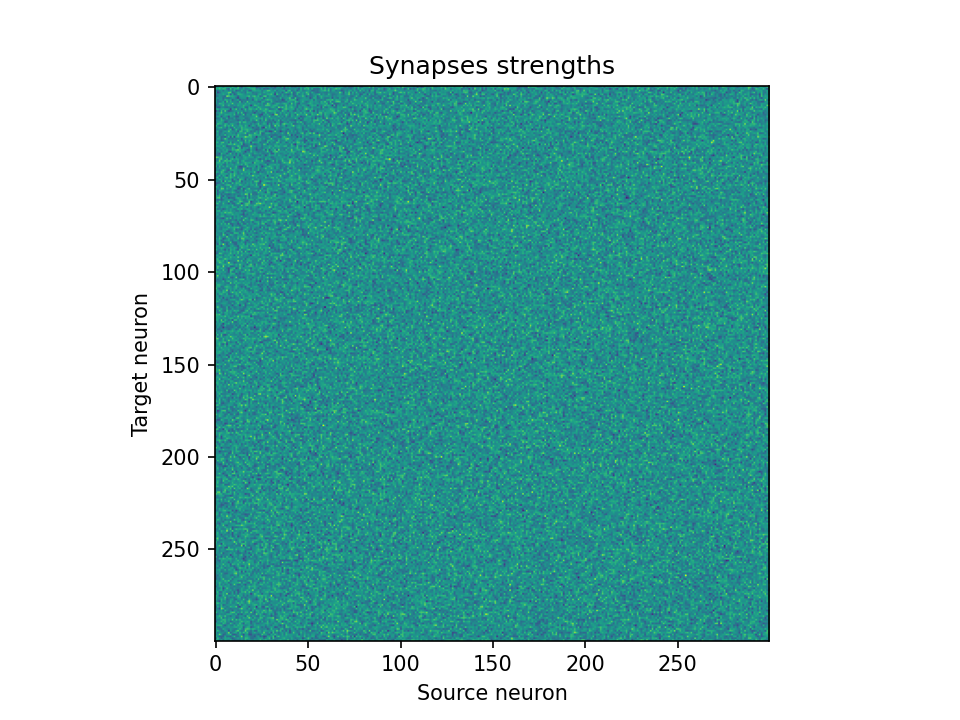

Text(0.5, 1.0, 'Synapses strengths')

In [3]:
#Plotting the synapse's matrix
figure, subplot = plt.subplots(1)
subplot.imshow(init_synapses(n_neurons), aspect = 'equal')
subplot.set_xlabel("Source neuron")
subplot.set_ylabel("Target neuron")
subplot.set_title("Synapses strengths")

## Input
The input I is computed as:

$$I_{i}(t) = \eta_{i}(t) + (I_{i}(t - \Delta t) - \eta_{i}(t))e^{-\frac{\Delta t}{\tau}}$$

Where $\eta_{i}(t)$ is a white noise process with a time constant $\tau$.

This is done to ensure that the input of different neurons is not correlated.

In [ ]:
tau_input = 0.1 #The time constant of the input
dt = 0.01 / 5 #The timestep of the input
scale_input = 0.01 #The scale of the input

def compute_input(n_neurons, tau_input, scale_input, dt, sim_time):
    n_timesteps = int(np.ceil(sim_time / dt)) #The number of timesteps
    eta = npr.randn(n_neurons, n_timesteps) * math.sqrt(tau_input / dt) #The noise process
    I = np.ones((n_neurons, n_timesteps)) #Initializing the input

    for i in range(1, n_timesteps): #Computing the input
        I[:, i] = eta[:, i] + (I[:, i - 1] - eta[:, i]) * np.exp(-dt / tau_input)

    return I * scale_input

I = compute_input(300, tau_input, scale_input, dt, 12)

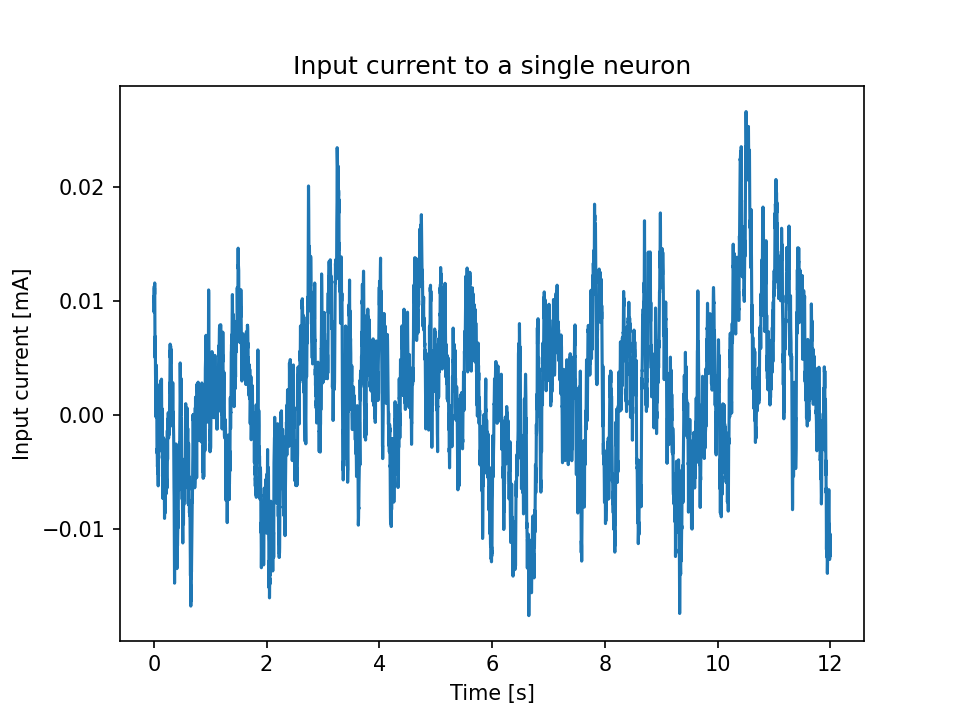

Text(0.5, 1.0, 'Input current to a single neuron')

In [4]:
#Plotting the input coming to a single neuron
figure, subplot = plt.subplots(1)

subplot.plot(
        np.arange(0, 12, dt),
        I[0, :])
subplot.set_xlabel("Time [s]")
subplot.set_ylabel("Input current [mA]")
subplot.set_title("Input current to a single neuron")

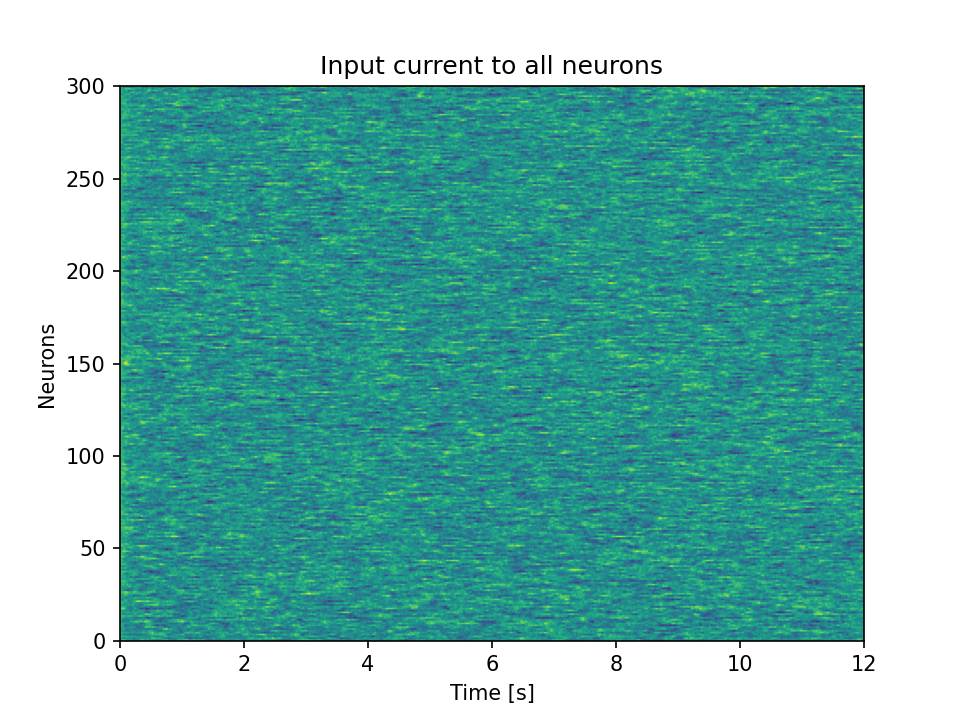

Text(0.5, 1.0, 'Input current to all neurons')

In [5]:
#Plotting the input coming to all the neurons
figure, subplot = plt.subplots(1)

subplot.imshow(I, extent = [0, 12, 0, n_neurons], aspect = 'auto')
subplot.set_xlabel("Time [s]")
subplot.set_ylabel("Neurons")
subplot.set_title("Input current to all neurons")

## Activation function
The activation function is any non-linear function like:
* The sigmoid.
* The hyperbolic tangent.
* The rectified linear unit (ReLU)

In this case the hyperbolic tangent is used:

$$\phi(x) = \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

With its derivative:

$$\phi'(x) = 1 - \tanh^{2}(x) = 1 - \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}^{2}$$

In [ ]:
phi = np.tanh

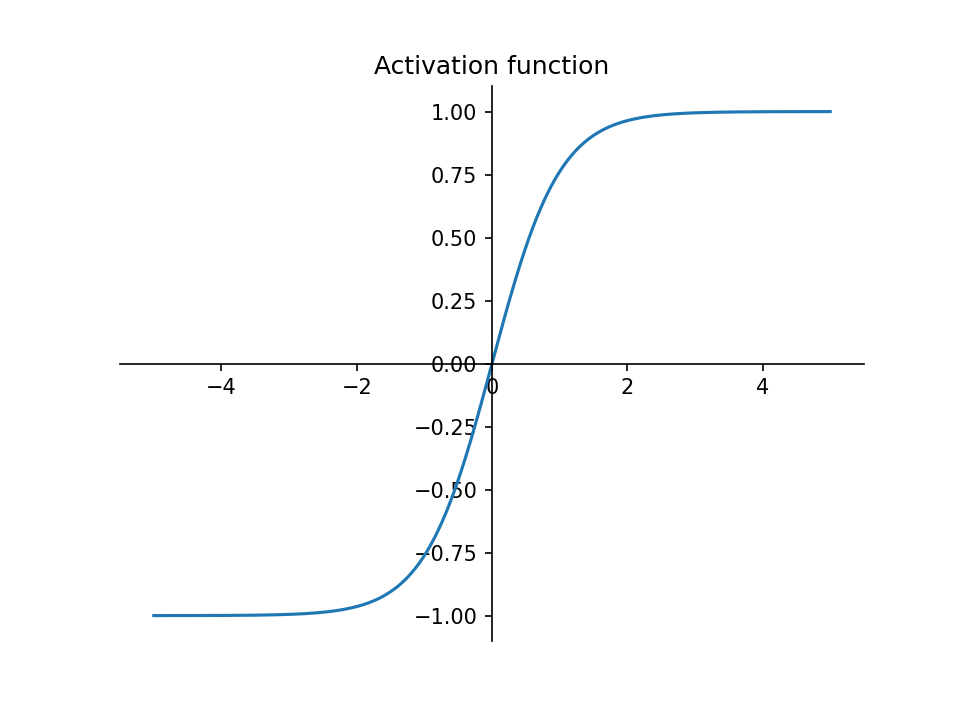

In [6]:
#Plotting the activation function
x = np.linspace(-5, 5, 1000)
y = phi(x)
figure, subplot = plt.subplots(1)
subplot.spines['left'].set_position('center')
subplot.spines['bottom'].set_position('center')
subplot.spines['right'].set_color('none')
subplot.spines['top'].set_color('none')
subplot.xaxis.set_ticks_position('bottom')
subplot.yaxis.set_ticks_position('left')
subplot.set_title("Activation function")
subplot.plot(x, y)

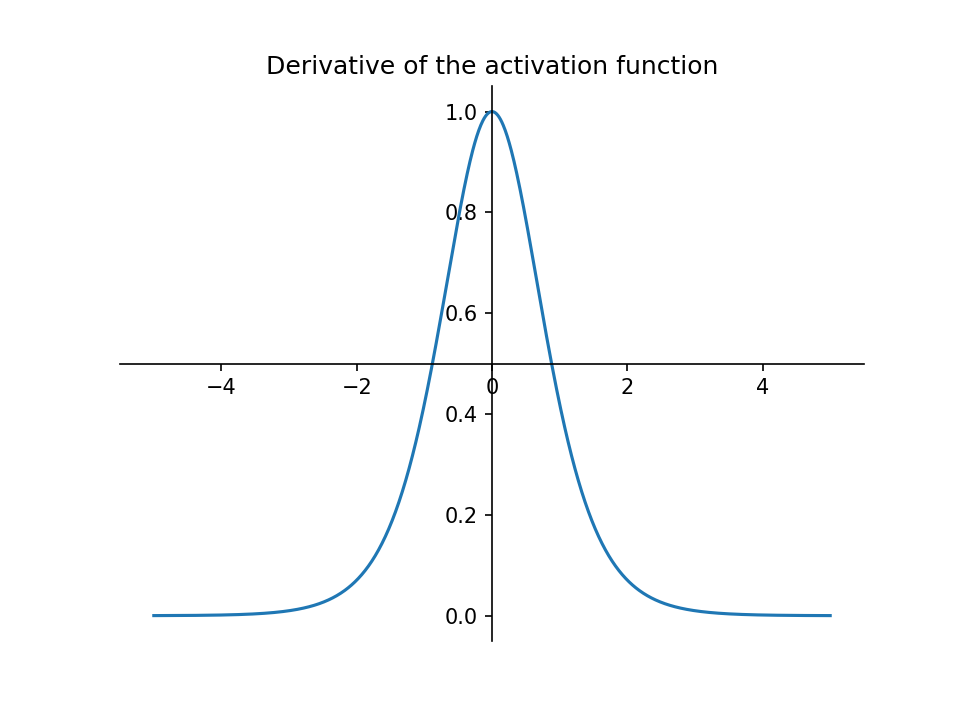

In [7]:
#Plotting the activation function's derivative
figure, subplot = plt.subplots(1)
subplot.spines['left'].set_position('center')
subplot.spines['bottom'].set_position('center')
subplot.spines['right'].set_color('none')
subplot.spines['top'].set_color('none')
subplot.xaxis.set_ticks_position('bottom')
subplot.yaxis.set_ticks_position('left')
subplot.set_title("Derivative of the activation function")
subplot.plot(x, 1 - y**2)

# Training
Training consists of updating the strength of the synapses connections $J_{ij}$ so that the activity of the neurons is as close as possible to the one found in the experimental data.
This is done by computing the error between the experimental data and the output of the network and then updating the synapses connections according to it:

$$J_{ij}(t) = J_{ij}(t-1) + \Delta J_{ij}(t)$$

$$\Delta J_{ij}(t) = c\cdot e_{i}(t)\sum\limits_{k=1}^N P_{jk}(t)\phi_{k}(t)$$

## Error function
The error function is the difference between the experimental data and the output of the network:

$$e_{i}(t) = z_{i}(t) - a_{i}(t)$$

In [ ]:
def get_error(simulated, experimental):
    return simulated - experimental

## Inverse cross-correlation matrix
$P$ is the inverse cross-correlation matrix of the firing rate of two neurons in the network:

$$P_{ij} = \langle\phi_{i}\phi_{j}\rangle^{-1}$$

This is costly to compute at every timestep, so it is computed iteratively as:

$$P(t) = P(t-1) - c\cdot ||(P(t-1)\cdot\phi(t))|| = P(t-1) - c\cdot((P(t-1)\cdot\phi(t))(P(t-1)\cdot\phi(t))^T)$$

With:

$$P(0) = \lambda\cdot I$$

Where $\lambda$ is the learning rate

In [ ]:
learning_rate = 1.0 #Works best when set to be 1 to 10 times the overall amplitude of the external inputs

#Initializing the inverse cross-correlation matrix
def init_P(n_neurons, learning_rate):
    return learning_rate * np.eye(n_neurons)

In [ ]:
#Computing the dot product of the inverse cross-correlation
#matrix and the activity of the neurons, this is a helper
#function that will be used in a number of methods.
def get_activity_P(P, activity):
    return P.dot(activity)

In [ ]:
#Defining the iterative computation of P
def update_P(P, activity_P, c):
    return P - c * activity_P.dot(activity_P.T)

## Scaling term
The scaling term $c$ scales the update of the synapses connections.
It is computed as:

$c = \frac{1}{1+\phi^{T}(t)\cdot(P(t-1)\cdot\phi(t))}$

In [ ]:
def get_c(activity_P, activity):
    aPa = activity.T.dot(activity_P).item() # The result is a singleton, item extracts the number
    return 1 / (1 + aPa)

## Update of the synapses Matrix
Recall:

$$\Delta J_{ij}(t) = c\cdot e_{i}(t)\sum\limits_{k=1}^N P_{jk}(t)\phi_{k}(t)$$

In [ ]:
#target_neurons is a list of the indices of neurons targeted by
#learning. This is necessary as the experimental data could contain the
#firing rates of only a subset of neurons in the network.
def update_J(J, activity_P, error, c, target_neurons):
    return J[:, target_neurons] - c * np.outer(error.flatten(), activity_P.flatten())

## Training function
Now that all the function have been defined, they can be collected in a single function that performs the training of the network.

In [ ]:
def train(simulated, experimental, J, P, target_neurons):
    error = get_error(simulated, experimental)
    activity_P = get_activity_P(P, simulated[target_neurons,:])
    c = get_c(activity_P, simulated[target_neurons,:])
    P = update_P(P, activity_P, c)
    J[:, target_neurons.flatten()] = update_J(J, activity_P, error, c, target_neurons)
    return J, P, np.mean(error ** 2)

# The experimental data
To demonstrate the capabilities of the network the experimental data will be generated in silico as well.
The data will be generated according to a three region ground truth model.
Each of the tree regions will contain $100$ neurons and will be driven by a different type of input:

* The first region (A) will be driven by only by the recurrent inputs from the other two regions.
* The second region (B) will be driven by a network generating a Gaussian "bump" $Q_{i}(t)$ propagating agross the network:
* The final region (C) will be driven by a network generating a fixed point that is shifted then to another during the generation.
The fixed points are generated by sampling $SQ_{i}(t)$ at two differend time points and holding them at the sampled value for the duration of the fixed point.

External inputs are connected to half of the units in their respective regions with a fixed negative weight (inhibitory) for region B and positive (excitatory) for region C.

## Generating the external inputs

### The Gaussian bump
The Gaussian bump is computed as:

$$SQ_{i}(t) = e^{-\frac{1}{2\sigma^2}\left(\frac{1-\sigma-Nt}{T}\right)^2}$$

Where:
* $\sigma$ is the width of the bump across the population.
* $N$ the population size.
* $t$ the total simulation time.

In [ ]:
#Cutoff_translation is used to compute when the bump stops moving between neurons
#and starts to remain fixed
def compute_x_bump(sim_time, dt, n_neurons, width, cutoff_traslation):
    """Selects which neurons have a higher firing rate.
    They will be sampled from a Gaussian distrubtion
    """
    n_samples = int(math.ceil(sim_time / dt))
    t_data = np.arange(0, sim_time, dt)
    x_bump = np.zeros((n_neurons, n_samples))
    n_width = width * n_neurons #from percentage to number
    norm = 2*n_width **2
    cutoff = math.ceil(n_samples / 2) + cutoff_traslation

    for i in range(n_neurons):
        x_bump[i, :] = np.exp(- ((i - n_width - n_neurons * t_data / (t_data[-1] / 2)) **2 / norm))
        x_bump[i, cutoff:] = x_bump[i, cutoff]

    return x_bump

### Sequence driving network
The sequence driving network takes the Gaussian bump and shifts it across neruons in a sequential manner until the cutoff.

In [ ]:
#The lead time is a "resting time" put at the beginning of the current,
#Where it remains constant.
def sequence_driving_network(x_bump, dt , lead_time):
    hbump = np.log((x_bump + 0.01)/(1-x_bump+0.01))
    #Shift to zero
    hbump = hbump - np.min(hbump)
    #Normalization
    hbump = hbump / np.max(hbump)
    #Add lead time
    newmat = np.tile(hbump[:, 1, np.newaxis], (1, math.ceil(lead_time / dt)))
    hbump = np.concatenate((newmat, hbump), axis=1)
    return hbump

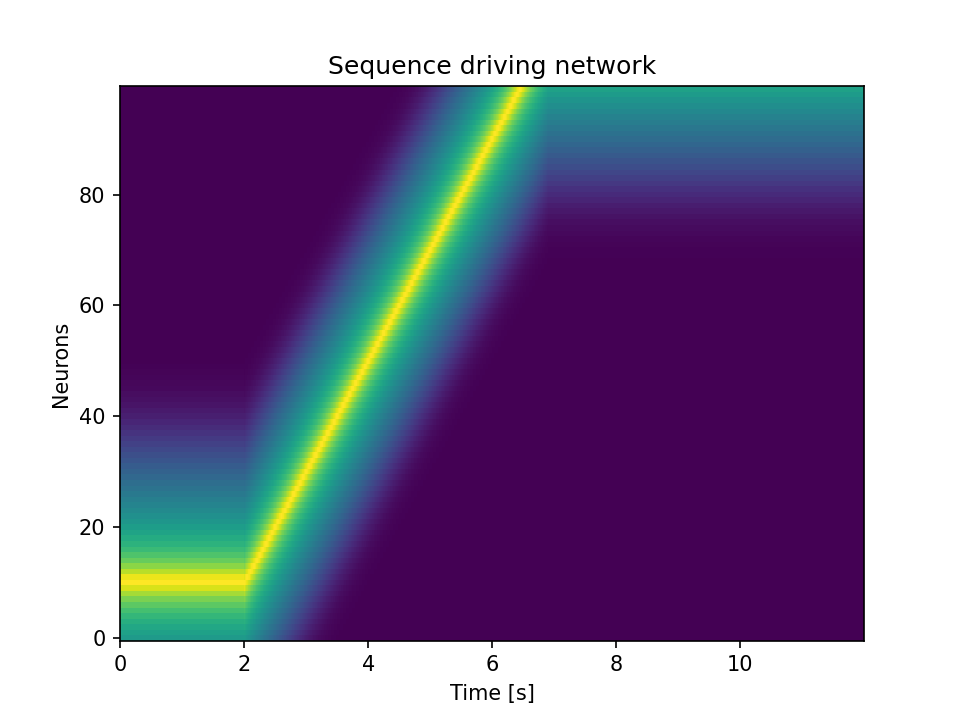

Text(0.5, 1.0, 'Sequence driving network')

In [8]:
#Plotting an example of a sequence driving network.
x_bump = compute_x_bump(10, 0.01, 100, 0.1, -10)
test = sequence_driving_network(x_bump, 0.01, 2)
figure, subplot = plt.subplots(1)
plt.pcolormesh(np.arange(0, 12, 0.01), np.arange(0, 100), test)
subplot.set_xlabel("Time [s]")
subplot.set_ylabel("Neurons")
subplot.set_title("Sequence driving network")

### Fixed point driving network
The fixed point driving network generates a fixed point that it is kept fixed until a certain point during the simulation, where it is traslated to another neuron.

In [ ]:
#Generates a fixed point that is shifted during the simulation,
#cutoff_translation: where the shift happen
#before_shift where to pick the current from x_bump before the shift
#after_shift where to pick the current from x_bump after the shift
def fixed_point_driver(xbump, sim_time, lead_time, dt, n_neurons, cutoff_traslation, before_shift, after_shift):
    n_samples = int(math.ceil((sim_time - lead_time) / dt))
    x_fp = np.zeros(xbump.shape)
    cutoff = math.ceil(n_samples / 2) + cutoff_traslation
    for i in range(n_neurons):
        front = xbump[i, before_shift] * np.ones((1, cutoff))
        back = xbump[i, after_shift] * np.ones((1, n_samples - cutoff))
        x_fp[i, :] = np.concatenate((front, back), axis = 1)
    y_fp = np.log((x_fp + 0.01)/(1-x_fp+0.01))
    #Shift to zero
    y_fp -= np.min(y_fp)
    #Normalization
    y_fp = y_fp / np.max(y_fp)
    #Add leading time
    newmat = np.tile(y_fp[:, 1, np.newaxis], (1, math.ceil(lead_time/dt)))
    y_fp = np.concatenate((newmat, y_fp), axis=1)
    return y_fp

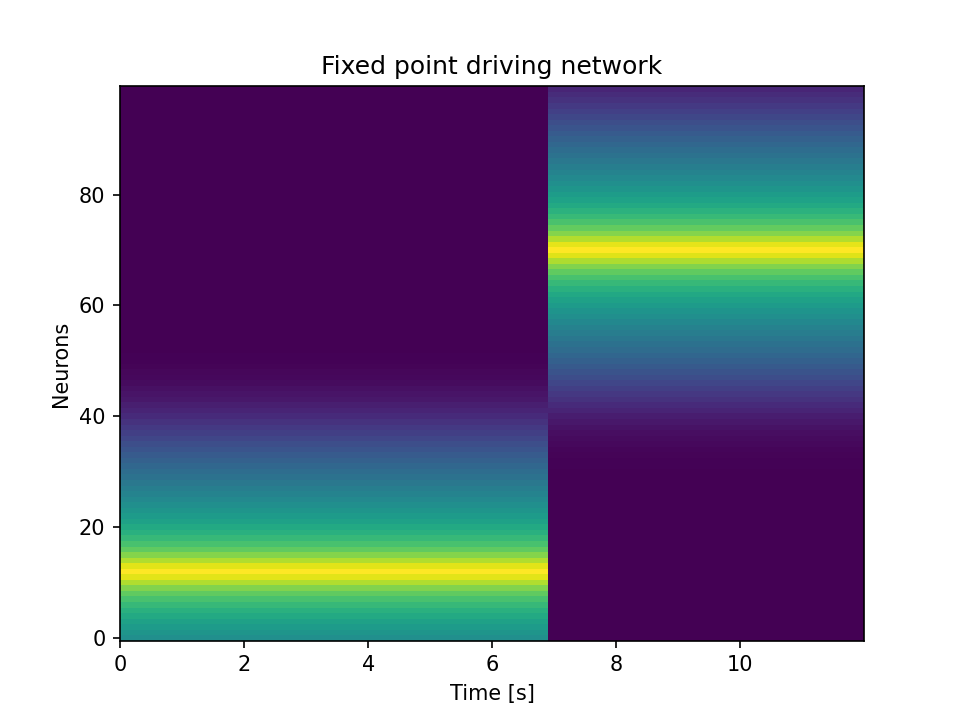

Text(0.5, 1.0, 'Fixed point driving network')

In [9]:
#Plot of an example of fixed point driver
test = fixed_point_driver(x_bump, 12, 2, 0.01, 100, -10, 10, 300)
figure, subplot = plt.subplots(1)
plt.pcolormesh(np.arange(0, 12, 0.01), np.arange(0, 100), test)
subplot.set_xlabel("Time [s]")
subplot.set_ylabel("Neurons")
subplot.set_title("Fixed point driving network")

## Connectivity

### Intra-region connectivity
Each of the three regions will have random inter-connections.
The strength of the connection is sampled by a normalized normal distribution:

$$J_{ij} \sim \mathcal{N}(0, \frac{1}{\sqrt{N_{in}}})$$

And then scaled by a chaos factor $g$:

$$J_{ij} = g\cdot J_{ij}$$

$g$ has to be sufficiently large so to facilitate chaotic dynamics in the network.

In [ ]:
def intra_region_connectivity(n_neurons, g):
    J = npr.randn(n_neurons, n_neurons)
    J = (g / np.sqrt(n_neurons)) * J
    return J

Text(0.5, 0, 'Neurons')


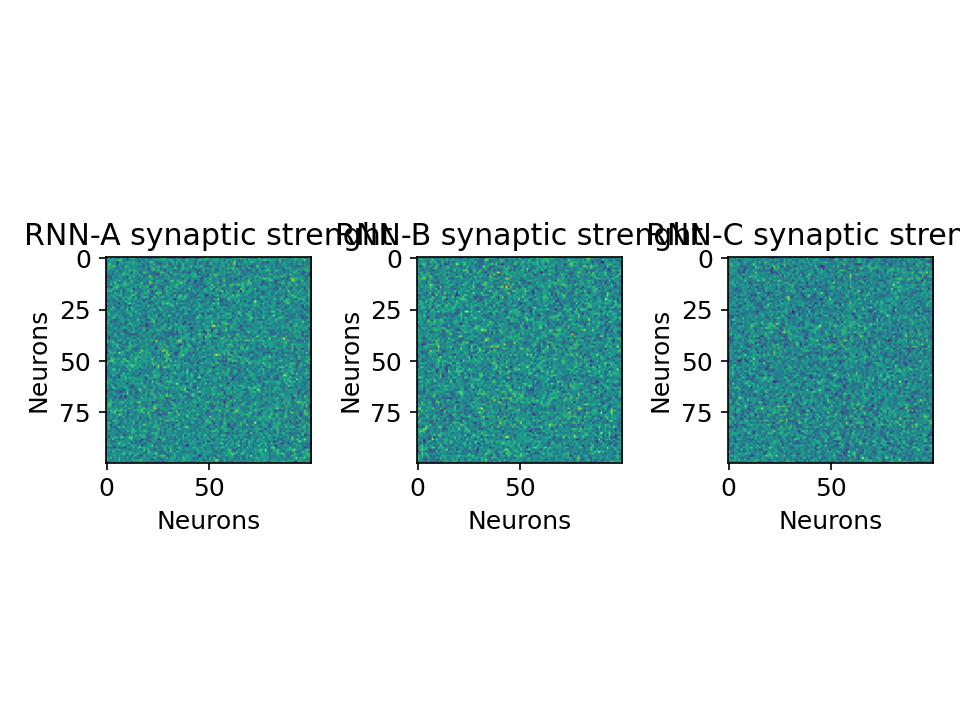

In [10]:
#Plotting some example of intra-region connectivity
J_a = intra_region_connectivity(100, 1.8)
J_b = intra_region_connectivity(100, 1.5)
J_c = intra_region_connectivity(100, 1.5)
plt.rcParams.update({'font.size': 12})

figure, subplot = plt.subplots(1, 3, layout = 'tight')
subplot[0].imshow(J_a, aspect = 'equal')
subplot[0].set_title("RNN-A synaptic strenght")
subplot[0].set_ylabel("Neurons")
subplot[0].set_xlabel("Neurons")
subplot[1].imshow(J_b, aspect = 'equal')
subplot[1].set_title("RNN-B synaptic strenght")
subplot[1].set_ylabel("Neurons")
subplot[1].set_xlabel("Neurons")
subplot[2].imshow(J_c, aspect = 'equal')
subplot[2].set_title("RNN-C synaptic strenght")
subplot[2].set_ylabel("Neurons")
subplot[2].set_xlabel("Neurons")

### Inter-region connectivity
The number of connection is controlled by the `frac_inter_reg`, which controls the percentage of connected neurons

In [ ]:
#Returns the array source_neurons of the neurons
#in the source population, where source_neurons[i] = 1 if
#neuron i is connected to the population and 0 otherwise
def source_region_neurons_connected(n_neurons, connected_fraction):
    n_connected = int(n_neurons * connected_fraction)
    source_neurons = np.zeros((n_neurons, 1))
    random_connected_neurons = npr.permutation(n_neurons)
    source_neurons[random_connected_neurons[0:n_connected]] = 1
    return source_neurons

In [11]:
frac_inter_reg = 0.05
connection_A_to_B = source_region_neurons_connected(100, frac_inter_reg)

frac_external_reg = 0.5

connection_sequence_to_B = source_region_neurons_connected(100, frac_external_reg)

print("The number of connection between A and B is: ", np.sum(connection_A_to_B))
print("The number of connection between the sequence driver and B is: ", np.sum(connection_sequence_to_B))

The number of connection between A and B is:  5.0
The number of connection between the sequence driver and B is:  50.0


## Initial state
The initial state is a `n_neurons` vector of values sampled from a normal distribution.

In [ ]:
def get_initial_state(n_neurons):
    return 2 * npr.rand(n_neurons, 1) - 1

## Generating the data
To generate the data a number of parameters is necessary, so they are all collected in a dictionary.

In [ ]:
data_params = {
        'sim_time' : 12,
        'lead_time' : 2,
        'dt' : 0.01,
        'bump_width' : 0.2,
        'n_neurons_A' : 100,
        'n_neurons_B' : 100,
        'n_neurons_C' : 100,
        'g_A' : 1.8,
        'g_B' : 1.5,
        'g_C' : 1.5,
        'frac_inter_reg' : 0.05,
        'frac_ext_reg' : 0.5,
        'activation_function' : np.tanh,
        'tau' : 0.1,
        'amplitude_inter_region' : 0.02,
        'amplitude_sequential' : 1,
        'amplitude_fixed' : -1,
        'cutoff_traslation' : 100,
        'before_shift' : 10,
        'after_shift' : 300,
        }

n_datapoints = int(data_params['sim_time'] / data_params['dt'])
data = {}
connections = {}

### Setting up all the necessary variables

In [ ]:
x_bump = compute_x_bump(
        data_params['sim_time'] - data_params['lead_time'],
        data_params['dt'],
        data_params['n_neurons_B'],
        data_params['bump_width'],
        -data_params['cutoff_traslation'],
        )

#Will contain the experimental data that will be fed into
#the training algorithm
data = {
        'A' : np.empty((data_params['n_neurons_A'], n_datapoints)),
        'B' : np.empty((data_params['n_neurons_B'], n_datapoints)),
        'C' : np.empty((data_params['n_neurons_C'], n_datapoints)),
        'sequential' : sequence_driving_network(
            x_bump,
            data_params['dt'],
            data_params['lead_time']
            ),
        'fixed' : fixed_point_driver(
            x_bump,
            data_params['sim_time'],
            data_params['lead_time'],
            data_params['dt'],
            data_params['n_neurons_C'],
            data_params['cutoff_traslation'],
            data_params['before_shift'],
            data_params['after_shift'],
            ),
        }

data['A'][:] = np.NaN
data['B'][:] = np.NaN
data['C'][:] = np.NaN

#The states of the neurons in each regions.
states = {
        'A' : get_initial_state(data_params['n_neurons_A']),
        'B' : get_initial_state(data_params['n_neurons_B']),
        'C' : get_initial_state(data_params['n_neurons_C']),
        }
#The connection between regions.
connections['A'] = {
        'A' : {
            'J' : intra_region_connectivity(
                data_params['n_neurons_A'],
                data_params['g_A']
                ),
            },
        'B' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_A'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        'C' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_A'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        }
connections['B'] = {
        'A' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_B'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        'B' : {
            'J' : intra_region_connectivity(
                data_params['n_neurons_B'],
                data_params['g_B']
                ),
            },
        'C' : {
            'region' : 'C',
            'J' : source_region_neurons_connected(
                data_params['n_neurons_B'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        'sequential' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_B'],
                data_params['frac_ext_reg']
                ),
            'w' : data_params['amplitude_sequential'],
            },
        }
connections['C'] = {
        'A' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_C'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        'B' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_C'],
                data_params['frac_inter_reg']
                ),
            'w' : data_params['amplitude_inter_region'],
            },
        'C' : {
            'J' : intra_region_connectivity(
                data_params['n_neurons_C'],
                data_params['g_C']
                ),
        },
        'fixed' : {
            'J' : source_region_neurons_connected(
                data_params['n_neurons_C'],
                data_params['frac_ext_reg']
                ),
            'w' : data_params['amplitude_fixed'],
            },
        }

Text(0, 0.5, 'Neuron')


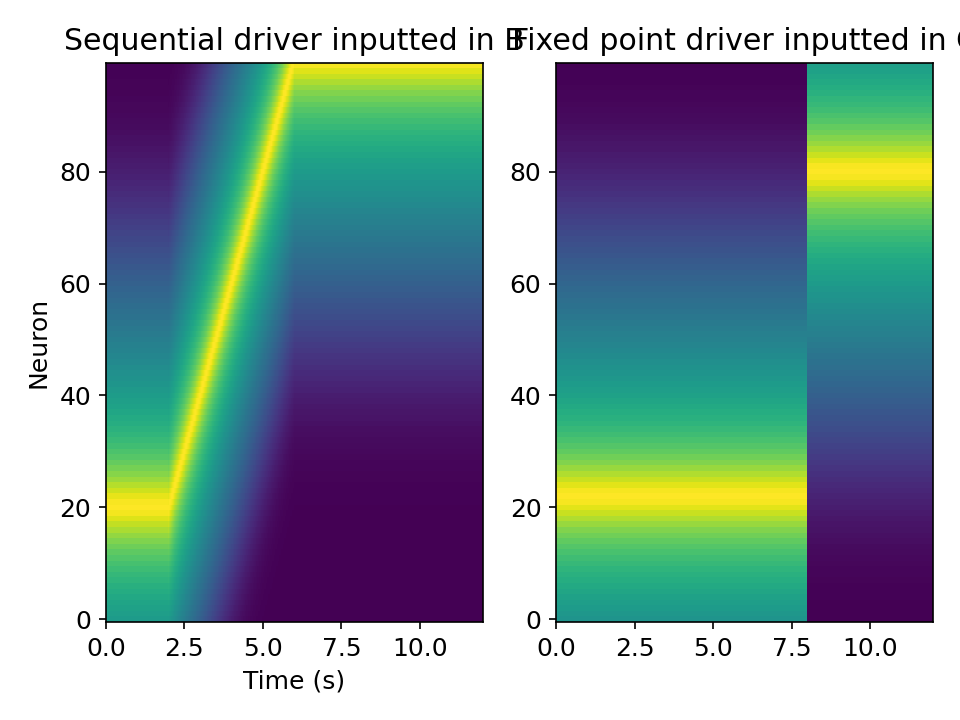

In [12]:
#Plotting the input currents
figure, subplots = plt.subplots(1, 2, layout = 'tight')
subplots[0].pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_B']),
        data['sequential'])
subplots[0].set_title("Sequential driver inputted in B")
subplots[0].set_xlabel("Time (s)")
subplots[0].set_ylabel("Neuron")

subplots[1].pcolormesh(
        np.arange(0, data_params['sim_time'], data_params['dt']),
        np.arange(0, data_params['n_neurons_C']),
        data['fixed'])
subplots[1].set_title("Fixed point driver inputted in C")
subplots[0].set_xlabel("Time (s)")
subplots[0].set_ylabel("Neuron")

### Updating the neurons and saving the data
Here two functions are defined:
* `save_states` saves the states of the neurons in the data dictionary.
* `update_states` updates the states of the neurons in the states dictionary.

Neurons are updated according to the equation:

$$r_{region, i}(t) = r_{region, i}(t - \Delta t) + \frac{\Delta t}{\tau} \left( -r_{region, i}(t - \Delta t) + \Delta r_{region, i}(t) \right)$$

Where:

$$\Delta r_{region, i}(t) = g_{region}J_{region}r_{region, i}(t-\Delta t) + \sum_{region'} w_{region, region'}J_{region, region'}r_{region', i}(t-\Delta t)$$

In [ ]:
def update_states(data, states, connections, dt, tau, t):
    for target in states:
        #The weight for intra-region connection is already included in J
        JR = connections[target][target]['J'].dot(data[target][:, t, np.newaxis])
        for source in connections[target]:
            if source != target:
                JR += connections[target][source]['w'] *\
                        connections[target][source]['J'] *\
                        data[source][:, t, np.newaxis]
        states[target] += dt * (-states[target] + JR) / tau
    return states

def save_states(data, states, phi, t):
    for region in states:
        data[region][:, t, np.newaxis] = phi(states[region])
    return data

In [ ]:
for t in range(n_datapoints):
    data = save_states(
            data,
            states,
            data_params['activation_function'],
            t
            )
    states = update_states(
            data,
            states,
            connections,
            data_params['dt'],
            data_params['tau'],
            t
            )

#Data normalization
for i in data:
    data[i] = data[i] / np.max(data[i])

#Concatenating the data in one big network
experimental_data = np.concatenate((data['A'], data['B'], data['C']), axis = 0)
#Normalization
experimental_data = experimental_data/experimental_data.max()
#Clipping to a maximum and minimum value
experimental_data = np.minimum(experimental_data, 0.999)
experimental_data = np.maximum(experimental_data, -0.999)

### Plotting the obtained experimental data

In [ ]:
def plot_region(data_params, data, region):
    figure, subplots = plt.subplots(1, 3, layout = 'tight')
    subplots[0].pcolormesh(
            np.arange(0, data_params['sim_time'], data_params['dt']),
            np.arange(0, data_params[f'n_neurons_{region}']),
            data[region]
            )
    subplots[0].set_title("Neural activity")
    subplots[0].set_xlabel("Time (s)")
    subplots[0].set_ylabel("Neuron")

    subplots[1].pcolormesh(
            np.arange(0, data_params[f'n_neurons_{region}']),
            np.arange(0, data_params[f'n_neurons_{region}']),
                      connections[region][region]['J']
                      )
    subplots[1].set_title("Synapses strenght")
    subplots[1].set_xlabel("Time (s)")
    subplots[1].set_ylabel("Neuron")

    #Some example neurons
    for _ in range(3):
        idx = npr.randint(0, data_params[f'n_neurons_{region}'] - 1)
        subplots[2].plot(
                np.arange(0, data_params['sim_time'], data_params['dt']),
                data[region][idx, :],
                )
    subplots[2].set_title("Neuron behaviur")
    subplots[2].set_xlabel("Time (s)")
    subplots[2].set_ylabel("Activity")

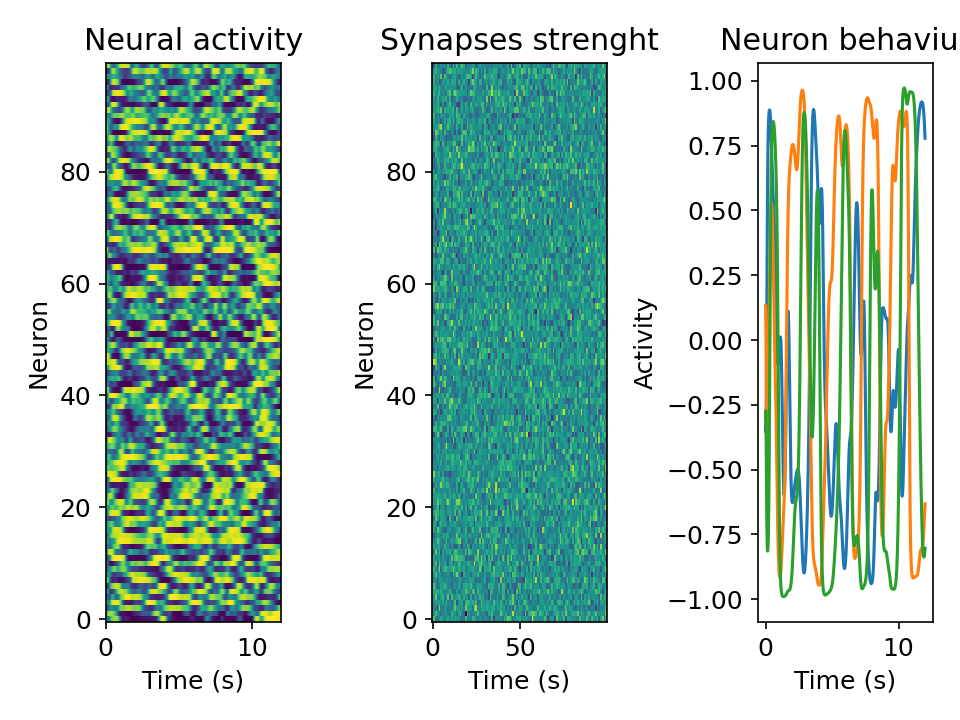

In [13]:
#Plotting the resulting data for region A
plot_region(data_params, data, 'A')

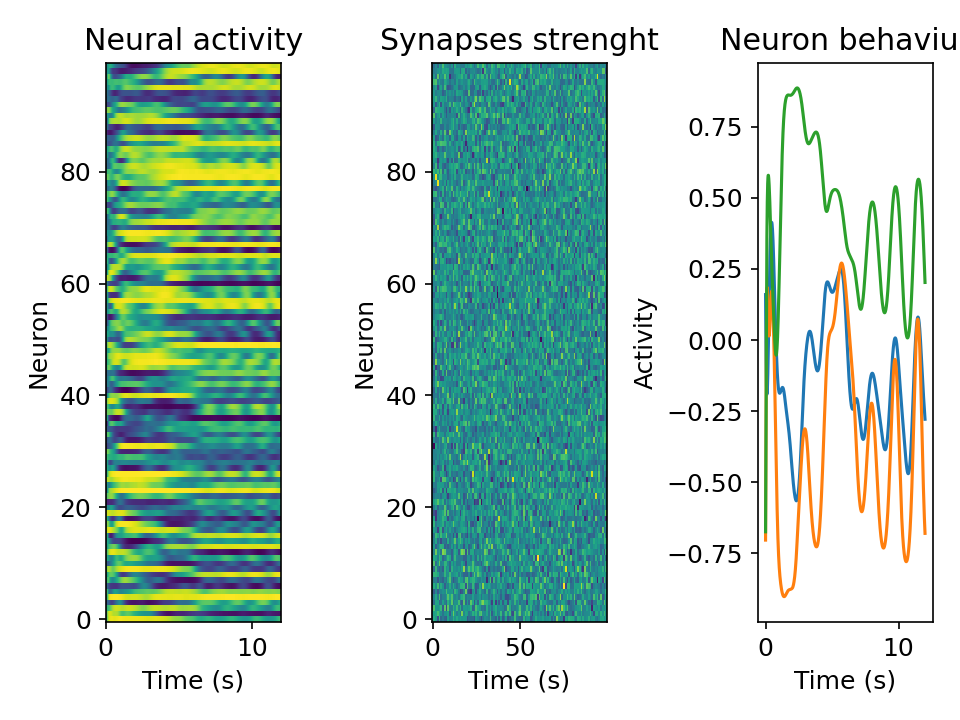

In [14]:
#Plotting the resulting data for region B
plot_region(data_params, data, 'B')

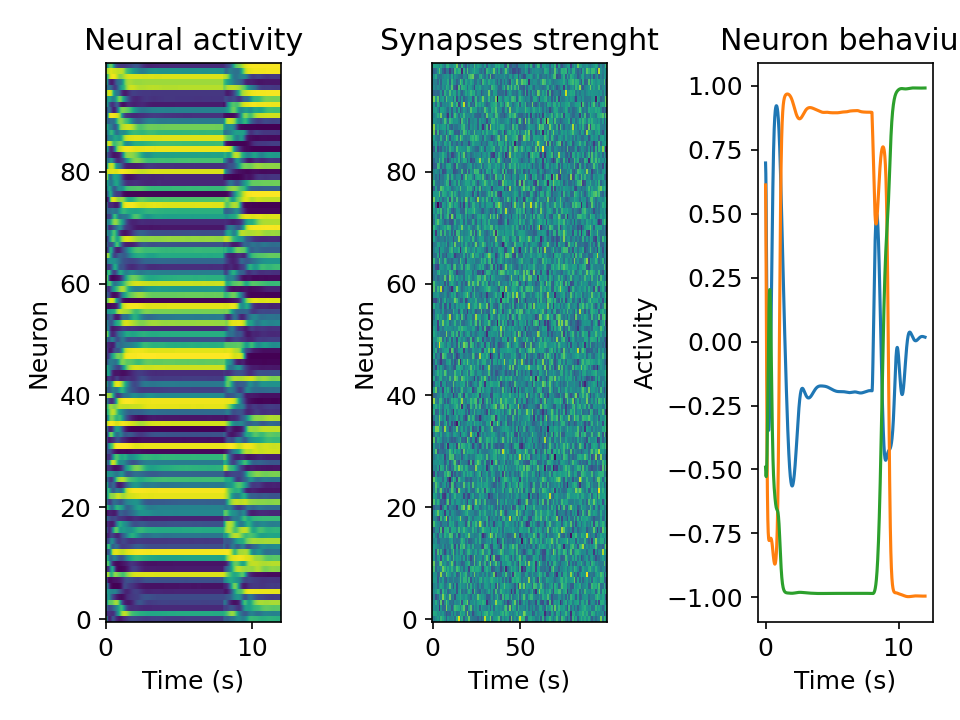

In [15]:
#Plotting the resulting data for region C
plot_region(data_params, data, 'C')

# In silico experiment example
The data obtained in the previous section will be used in the pipeline defined at the beginning of this notebook to train a recurrent neural network.
During the simulation two values will be recorded:

* `chi2` is the value of the chi-squared error between the output of the network and the experimental data.
* `pvar` is the value of the percentage of variance explained by the network.

The network will be trained to minimize the chi-squared error and maximize the percentage of variance explained.

## Initialization
Generating the network and the initial states.

In [ ]:
n_target_neurons = 300
#Randomizing the indices makes the network more robust
#and converge faster
learn_list = npr.permutation(n_target_neurons)
target_neurons = learn_list[:n_target_neurons]

sim_param = {
        'n_neurons' : 300,
        'g' : 1.2,
        'tau_neuron' : 0.1,
        'tau_input' : 0.1,
        'scale_input' : 0.01,
        'dt' : 0.002,
        'data_dt' : data_params['dt'],
        'sim_time' : data_params['sim_time'], #in seconds
        'learning_rate' : 1.0,
        'activation_function' : np.tanh,
        'target_neurons' : target_neurons,
        }

neurons = init_neurons(sim_param['n_neurons'])
J = init_synapses(sim_param['n_neurons'])
P = init_P(sim_param['n_neurons'], sim_param['learning_rate'])
H = compute_input(
        sim_param['n_neurons'],
        sim_param['tau_input'],
        sim_param['scale_input'],
        sim_param['dt'],
        sim_param['sim_time'])

## Training
To train the network a single run will have to be repeated a number of times.
During the run the network is left to evolve alone until it finds a data point in the experimental data.
At that point it will update the values of its synaptic connectivity $J$ to minimize the error with the experimental data

In [ ]:
def run(neurons, J, H, P, experimental_data, sim_param, training = True):
    timestep = 0
    chi2 = 0
    simulated_activity = np.zeros((sim_param['n_neurons'], int(sim_param['sim_time'] / sim_param['dt'])))
    n_timesteps = int(sim_param['sim_time'] / sim_param['dt'])
    while timestep < n_timesteps:
        activity = get_activity(neurons, sim_param['activation_function'])
        simulated_activity[:, timestep, np.newaxis] = activity
        neurons = update_voltage(neurons,
                                 sim_param['g'],
                                 J,
                                 H[:, timestep, np.newaxis],
                                 activity,
                                 sim_param['tau_neuron'],
                                 sim_param['dt'],
                                 )

        if training and timestep % int(sim_param['data_dt'] / sim_param['dt']) == 0:
            data_timestep = int(timestep / (sim_param['data_dt'] / sim_param['dt']))
            J, P, chi2_temp = train(
                    activity,
                    experimental_data[:, data_timestep, np.newaxis],
                    J,
                    P,
                    sim_param['target_neurons'],
                    )
            chi2 += chi2_temp
        timestep += 1
    return simulated_activity, J, P, chi2

In [16]:
#An example of a network run with training disabled (no updating of J)
non_trained, J, P, chi2 = run(neurons, J, H, P, experimental_data, sim_param, training = False)
distance = np.linalg.norm(experimental_data - non_trained[:, [i*5 for i in range(experimental_data.shape[1])]])
pvar = 1 - (distance / (math.sqrt(300 * 1200)) * np.std(experimental_data)) ** 2
print(chi2, pvar)

0 0.7843219595193507


In [17]:
figure, subplots = plt.subplots(1, 3, layout = 'tight')
subplots[0].imshow(
        test,
        extent = [
            0,
            sim_param['sim_time'],
            0,
            sim_param['n_neurons']
            ],
        aspect = 'auto'
        )
subplots[0].set_title("Simulated activity")
subplots[0].set_xlabel("Time (s)")
subplots[0].set_ylabel("Neuron")
subplots[1].imshow(
        experimental_data,
        extent = [
            0,
            sim_param['sim_time'],
            0,
            sim_param['n_neurons']
            ],
        aspect = 'auto')
subplots[1].set_title("Experimental activity")
subplots[1].set_xlabel("Time (s)")
subplots[1].set_ylabel("Neuron")
random_neuron_index = npr.choice(np.arange(0, sim_param['n_neurons'])
subplots[2].plot(
        np.arange(0, sim_param['sim_time'], sim_param['data_dt']),
        experimental_data[random_neuron_index, :],
        label = 'experimental'
        )
subplots[2].plot(
        np.arange(0, sim_param['sim_time'], sim_param['dt']),
        test[random_neuron_index, :],
        label = 'simulated'
        )
subplots[2].legend(bbox_to_anchor=(0.00, 0., 1., .102))
subplots[2].set_ylim(-1,1)
subplots[2].set_title("Neuron " + str(random_neuron_index))
subplots[2].set_xlabel("Time (s)")
subplots[2].set_ylabel("Activity")

  Cell In[69], line 27
    random_neuron_index = npr.choice(np.arange(0, sim_param['n_neurons'])
                                    ^
SyntaxError: '(' was never closed



In [ ]:
def plot_train_evolution(figure, subplots, chi2s, pvars, neuron_index, state, experimental_data, plots, sim_param):
    if not figure:
        plt.ion()
        figure, subplots = plt.subplots(2, 3, layout = 'tight')
        plots['exp_neuron'], = subplots[0, 2].plot(
                np.arange(0, sim_param['sim_time'], sim_param['data_dt']),
                experimental_data[neuron_index, :],
                label = 'experimental'
                )
        plots['sim_neuron'], = subplots[0, 2].plot(
                np.arange(0, sim_param['sim_time'], sim_param['dt']),
                state[neuron_index, :],
                label = 'simulated',
                )
        subplots[0,2].legend()
        subplots[0,2].set_ylim(-1,1)
        plots['state'] = subplots[0, 0].imshow(
                state,
                extent = [
                    0,
                    sim_param['sim_time'],
                    0,
                    sim_param['n_neurons']
                    ],
                aspect = 'auto'
                )
        subplots[0, 1].imshow(
                experimental_data,
                extent = [
                    0,
                    sim_param['sim_time'],
                    0,
                    sim_param['n_neurons']
                    ],
                aspect = 'auto'
                )
        plots['chi2'], = subplots[1, 0].plot(chi2s)
        plots['pvars'], = subplots[1, 1].plot(pvars)
        subplots[1, 2].set_visible(False)

        subplots[0, 0].set_title("Simulated neurons")
        subplots[0, 0].set_xlabel("Time (s)")
        subplots[0, 0].set_ylabel("Neuron")
        subplots[0, 1].set_title("Experimental neurons")
        subplots[0, 1].set_xlabel("Time (s)")
        subplots[0, 1].set_ylabel("Neuron")
        subplots[0, 2].set_title("Neuron {}".format(neuron_index))
        subplots[0, 2].set_xlabel("Time (s)")
        subplots[0, 2].set_ylabel("Activity")
        subplots[1, 0].set_title(r"$chi^2$")
        subplots[1, 0].set_xlabel("Iteration")
        subplots[1, 0].set_ylabel(r"$chi^2$")
        subplots[1, 1].set_title("pvar")
        subplots[1, 1].set_xlabel("Iteration")
        subplots[1, 1].set_ylabel("pvar")

    plots['sim_neuron'].set_ydata(state[neuron_index, :])
    plots['exp_neuron'].set_ydata(experimental_data[neuron_index, :])
    plots['state'].set_data(state)
    subplots[1, 0].plot(chi2s, c = 'g')
    subplots[1, 1].plot(pvars, c = 'g')

    figure.canvas.draw()
    figure.canvas.flush_events()

    return figure, subplots, plots


def met_stopping_condition(stopping_condition, epoch, chi2, pvar):
    stop = False
    for name in stopping_condition:
        if name == 'chi2':
            stop = stop or chi2 < stopping_condition[name]
        elif name == 'pvar':
            stop = stop or pvar > stopping_condition[name]
        elif name == 'epochs':
            stop = stop or epoch > stopping_condition[name]
        elif name == 'custom':
            stop = stop or stopping_condition[name]
    return stop


def network_train(neurons, J_in, H_in, P_in, experimental_data, sim_param, stopping_condition, plot = False):
    J = J_in.copy()
    H = H_in.copy()
    P = P_in.copy()
    state = None
    chi2s = []
    pvars = []
    epoch = 0
    figure, subplots, plots = None, None, {}
    random_neuron_index = npr.choice(target_neurons)
    stop = False
    while not stop:
        state, J, P, chi2 = run(neurons, J, H, P, experimental_data, sim_param)
        distance = np.linalg.norm(experimental_data - state[:, [i*5 for i in range(experimental_data.shape[1])]])
        pvar = 1 - (distance / (math.sqrt(300 * 1200)) * np.std(experimental_data)) ** 2
        chi2s.append(chi2)
        pvars.append(pvar)

        if plot:
            figure, subplots, plots = plot_train_evolution(
                    figure,
                    subplots,
                    chi2s,
                    pvars,
                    random_neuron_index,
                    state,
                    experimental_data,
                    plots,
                    sim_param
                    )

        epoch += 1
        stop = met_stopping_condition(stopping_condition, epoch, chi2, pvar)

    return state, J, P, chi2s, pvars

In [ ]:
stopping_condition = {
        'epochs' : 500,
        }
simulated_data, final_J, final_P, chi2s, pvars = network_train(
        neurons,
        J,
        H,
        P,
        experimental_data,
        sim_param,
        stopping_condition,
        plot = True
        )

# Analysis of the results
Having now provided a framework for building an in-silico replica of the dynamics of the neurons recorded during an experiment, we'll explore what properties can be inferred from the simulation.

## CURBD - Current based decomposition of multi-region datasets
The current into any one target neurons is the sum of the activities of all the neurons in the network scaled by the respective interaction weights:

$$I_{target} = \sum_{source} J_{source, target} \cdot activity_{source} = \sum_{source} J_{source, target} \cdot \phi(I_{source})$$

When applied to the whole network this equation can reconstruct the full activity of units in the target regions.
Moreover the equation can be restricted to source  units from a specific region, so to isolate the currents into the target region from a specific source one.

This is done by dividing the matrix $J$ into $M^2$ sub-matrices, where $M$ is the number of regions identified in the dataset (which for now should be known *a priori* for the scope of this discussion).

The separation of currents can be considered as a decomposition of the activity of the target-region neurons based on the relative contributions of each source one.

In [ ]:
regions = {
        'A' : np.arange(
            0,
            data_params['n_neurons_A']
            ),
        'B' : np.arange(
            data_params['n_neurons_A'],
            data_params['n_neurons_A'] + data_params['n_neurons_B']
            ),
        'C' : np.arange(
            data_params['n_neurons_A'] + data_params['n_neurons_B'],
            data_params['n_neurons_A'] + data_params['n_neurons_B'] + data_params['n_neurons_C']
            ),
        }

In [ ]:
def curbd(simulated_activity, J, regions, current_type):
    new_J = J.copy()

    if current_type == 'all':
        pass
    elif current_type == 'excitatory':
        new_J[new_J < 0] = 0
    elif current_type == 'inhibitory':
        new_J[new_J > 0] = 0
    else:
        raise ValueError("current_type must be 'all', 'excitatory' or 'inhibitory', not " + f"'{current_type}'")

    curbd = {}

    for target in regions:
        for source in regions:
            sub_J = new_J[regions[source], :][:, regions[target]]
            curbd[f"{source} {target}"] = sub_J.dot(simulated_activity[regions[source], :])

    return curbd

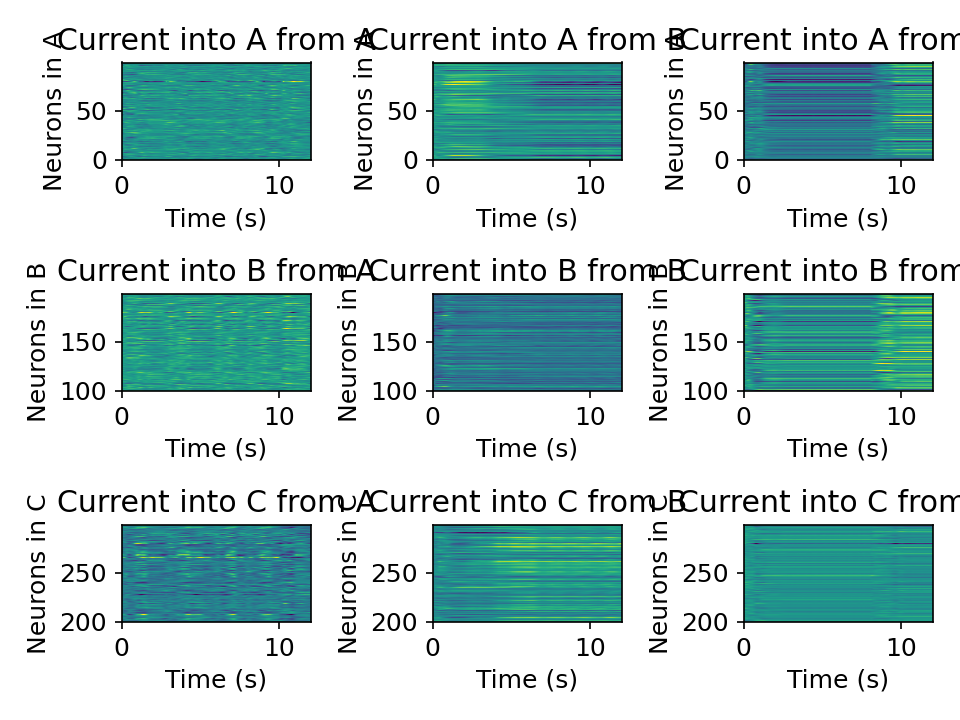

In [18]:
curbd_res = curbd(simulated_data, final_J, regions, current_type = 'all')

figure, subplot = plt.subplots(len(regions), len(regions), layout = 'tight')
for (i, region) in enumerate(curbd_res):
    subplot_col = i // len(regions)
    subplot_row = i % len(regions)
    subplot[subplot_col, subplot_row].pcolormesh(
            np.arange(0, sim_param['sim_time'], sim_param['dt']),
            regions[region.split()[-1]],
            curbd_res[region],
            )
    subplot[subplot_col, subplot_row].set_xlabel("Time (s)")
    subplot[subplot_col, subplot_row].set_ylabel(f"Neurons in {region.split()[-1]}")
    subplot[subplot_col, subplot_row].set_title(f"Current into {region.split()[-1]} from {region.split()[0]}")

## State space analysis
The state space analysis is based on principal component analysis and allows to describe the istantaneous network state.

The output of the training is fitted in a PCA and the eigenvalues of the corresponding matrix, expressed as a fraction of their sum indicate the distribution of variance across different orthogonal directions in the active trajectory.

This allows to define an effective dimensionality of the activity $N_{eff}$ as the number of prncipal components that capture $90\%$ of the variance in the dynamics.

In [ ]:
def pca_analysis(data, n_components):
    pca = PCA(n_components)
    pca.fit(data.T)
    proj = pca.transform(data.T)
    cum_explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
    return proj, cum_explained_variance_ratio

In [ ]:
n_components = 50

simulated_projections, cum_variance_simulated = pca_analysis(
        simulated_data,
        n_components,
        )

experimental_projections, cum_variance_experimental = pca_analysis(
        experimental_data,
        n_components,
        )

non_trained_projections, cum_variance_non_trained = pca_analysis(
        non_trained,
        n_components,
        )

Text(0.5, 0.92, 'Experimental data')


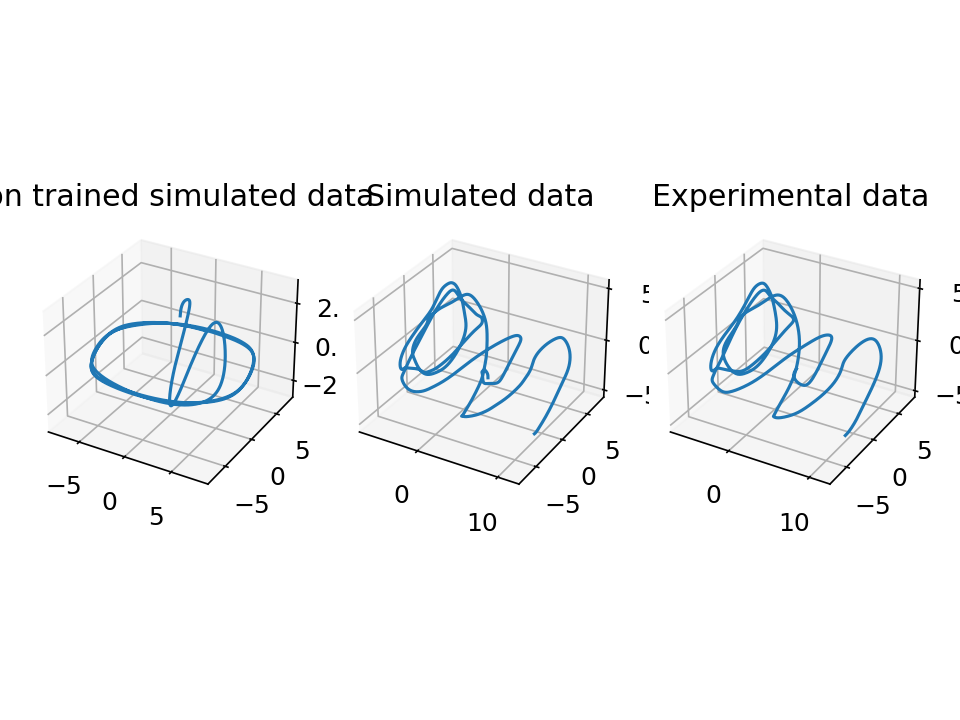

In [19]:
figure, subplot = plt.subplots(1, 3, subplot_kw = {'projection' : '3d'}, layout = 'tight')

subplot[0].plot(non_trained_projections[:, 0], non_trained_projections[:, 1], non_trained_projections[:, 2])
subplot[0].set_title("Non trained simulated data")

subplot[1].plot(simulated_projections[:, 0], simulated_projections[:, 1], simulated_projections[:, 2])
subplot[1].set_title("Simulated data")


subplot[2].plot(experimental_projections[:, 0], experimental_projections[:, 1], experimental_projections[:, 2])
subplot[2].set_title("Experimental data")

Text(0, 0.5, 'Variance')


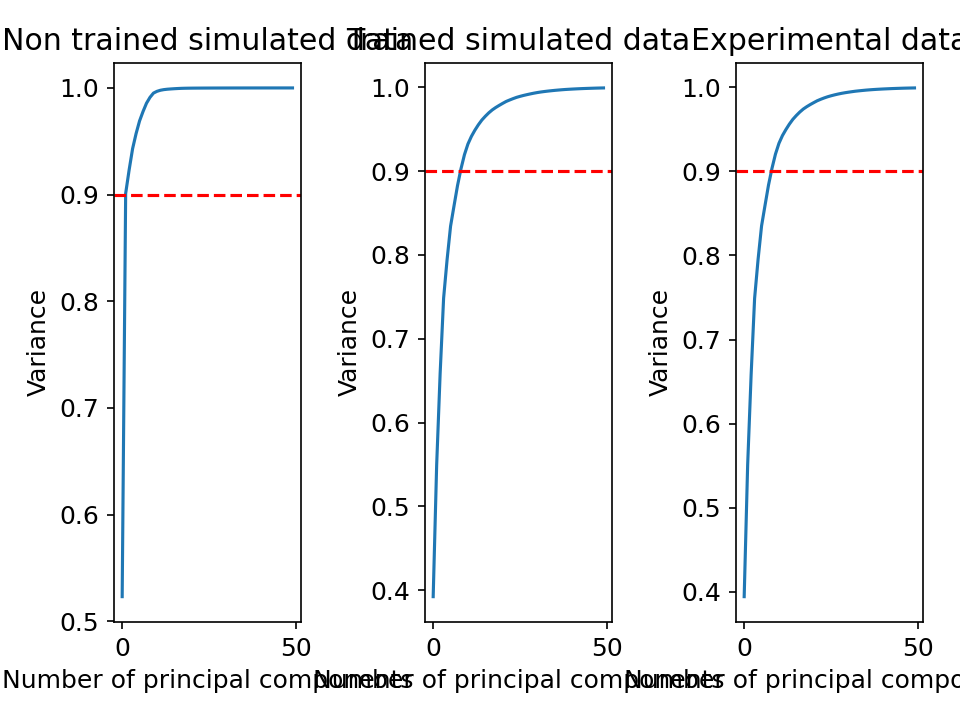

In [20]:
figure, subplot = plt.subplots(1, 3, layout = 'tight')
subplot[0].plot(cum_variance_non_trained)
subplot[0].axhline(0.9, color = 'red', ls = '--')
subplot[0].set_title("Non trained simulated data")
subplot[0].set_xlabel("Number of principal components")
subplot[0].set_ylabel("Variance")
subplot[1].plot(cum_variance_simulated)
subplot[1].axhline(0.9, color = 'red', ls = '--')
subplot[1].set_title("Trained simulated data")
subplot[1].set_xlabel("Number of principal components")
subplot[1].set_ylabel("Variance")
subplot[2].plot(cum_variance_experimental)
subplot[2].axhline(0.9, color = 'red', ls = '--')
subplot[2].set_title("Experimental data")
subplot[2].set_xlabel("Number of principal components")
subplot[2].set_ylabel("Variance")

In [21]:
#searchsorted stops at the first occurrence of a value > 0.9
non_train_sim = np.searchsorted(cum_variance_non_trained, 0.9)
sim = np.searchsorted(cum_variance_simulated, 0.9)
exp = np.searchsorted(cum_variance_experimental, 0.9)
print(f"Number of principal components in the simulation without training such that the captured variance is greater than 90%: {non_train_sim}")
print(f"Number of principal components in the simulation  with training such that the captured variance is greater than 90%: {sim}")
print(f"Number of principal components in the experiment such that the captured variance is greater than 90%: {exp}")

Number of principal components in the simulation without training such that the captured variance is greater than 90%: 1
Number of principal components in the simulation  with training such that the captured variance is greater than 90%: 8
Number of principal components in the experiment such that the captured variance is greater than 90%: 8


## Effective connectivity
The matrix $J$ of connectivity strenghts allow to describe the strength of connectivity between regions.

Plotting the hitogram of values of $J$ in a specific sub-region allow to infer how they are connected.

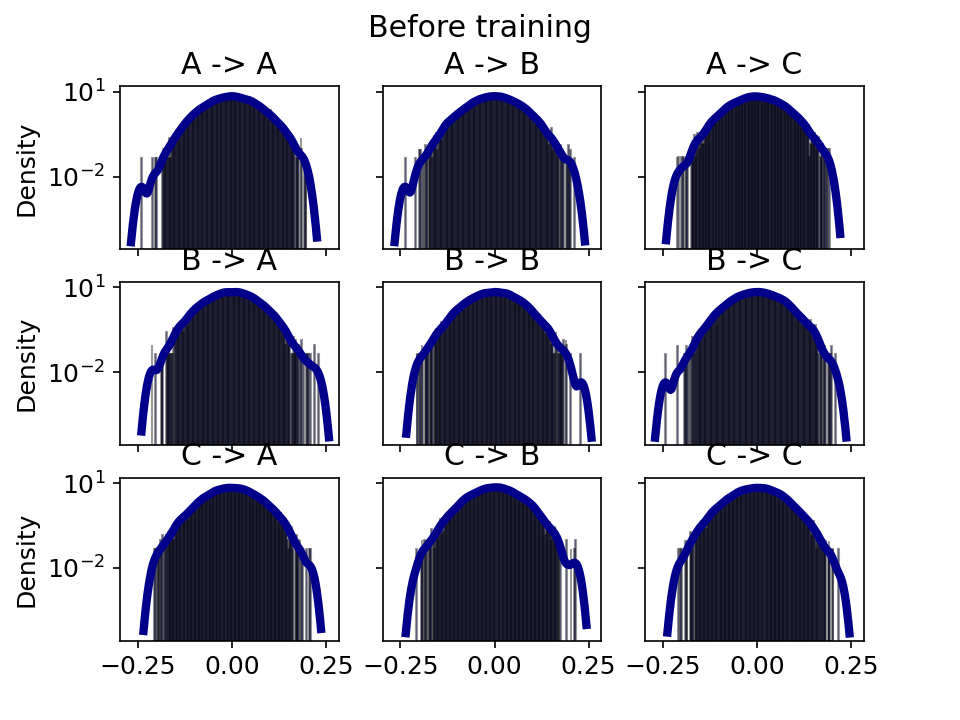

In [22]:
import seaborn as sns


figure, subplot = plt.subplots(len(regions), len(regions), sharex = True, sharey = True)
plt.suptitle("Before training")
for (i, source) in enumerate(regions):
    for (j, target) in enumerate(regions):
        sns.distplot(J[regions[source], :][:, regions[target]],
                     hist=True,
                     kde=True,
                     bins=200,
                     color = 'darkblue',
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 4},
                        ax=subplot[i, j])
        subplot[i, j].set_title(f"{source} -> {target}")
        subplot[i, j].set_yscale('log')

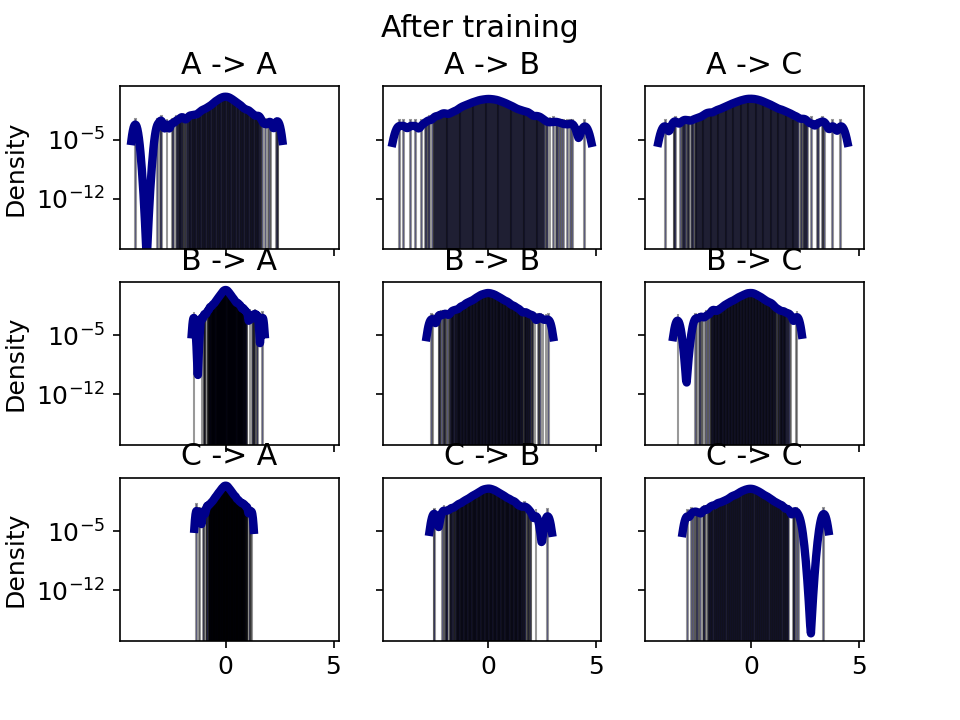

In [23]:
figure, subplot = plt.subplots(len(regions), len(regions), sharex = True, sharey = True)
figure.suptitle("After training")
for (i, source) in enumerate(regions):
    for (j, target) in enumerate(regions):
        sns.distplot(final_J[regions[source], :][:, regions[target]],
                     hist=True,
                     kde=True,
                     bins=200,
                     color = 'darkblue',
                     hist_kws={'edgecolor':'black'},
                     kde_kws={'linewidth': 4},
                        ax=subplot[i, j])
        subplot[i, j].set_title(f"{source} -> {target}")
        subplot[i, j].set_yscale('log')